## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On linux, you can use `pdfunite`, there are similar tools for other platforms, too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

# Matrix Factorization

In [3]:
import time
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
%matplotlib inline

# Restaurant recommendation

The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. For this, we try to predict the rating a user will give to a restaurant they have not yet rated based on a latent factor model.

Specifically, the objective function (loss) we wanted to optimize is:
$$
\mathcal{L} = \min_{P, Q} \sum_{(u, 1) \in W} (M_{ui} - \mathbf{q}_u\mathbf{p}_i^T)^2 + \lambda\sum_i{\left\lVert \mathbf{p}_i  \right\rVert}^2 + \lambda\sum_u {\left\lVert\mathbf{q}_u  \right\rVert}^2
$$

where $S$ is the set of $(u, i)$ pairs for which the rating $R_{ui}$ given by user $u$ to restaurant $i$ is known. Here we have also introduced two regularization terms to help us with overfitting where $\lambda$ is hyper-parameter that control the strength of the regularization.

The task it to solve the matrix factorization via alternating least squares _and_ stochastic gradient descent (non-batched, you may omit the bias).

**Hint 1**: Using the closed form solution for regression might lead to singular values. To avoid this issue perform the regression step with an existing package such as scikit-learn. It is advisable to use ridge regression to account for regularization.

**Hint 2**: If you are using the scikit-learn package remember to set ``fit_intercept = False`` to only learn the coefficients of the linear regression.

### Load and Preprocess the Data (nothing to do here) 

In [4]:
ratings = np.load("exercise_11_matrix_factorization_ratings.npy")

In [5]:
# We have triplets of (user, restaurant, rating).
ratings

array([[101968,   1880,      1],
       [101968,    284,      5],
       [101968,   1378,      2],
       ...,
       [ 72452,   2100,      4],
       [ 72452,   2050,      5],
       [ 74861,   3979,      5]])

Now we transform the data into a matrix of dimension [N, D], where N is the number of users and D is the number of restaurants in the dataset. We store the data as a sparse matrix to avoid out-of-memory issues.

In [6]:
n_users = np.max(ratings[:,0] + 1)
n_restaurants = np.max(ratings[:,1] + 1)
R = sp.coo_matrix((ratings[:,2], (ratings[:,0], ratings[:,1])), shape=(n_users, n_restaurants)).tocsr()
R.shape

(337867, 5899)

To avoid the <a href="https://en.wikipedia.org/wiki/Cold_start_(computing)"> cold start problem</a>, in the preprocessing step, we recursively remove all users and restaurants with 10 or less ratings.

Then, we randomly select 200 data points for the validation and test sets, respectively.

After this, we subtract the mean rating for each users to account for this global effect.

**Note**: Some entries might become zero in this process -- but these entries are different than the 'unknown' zeros in the matrix. We store the indices for which we the rating data available in a separate variable.

In [7]:
def cold_start_preprocessing(matrix, min_entries):
    """
    Recursively removes rows and columns from the input matrix which have less than min_entries nonzero entries.
    
    Parameters
    ----------
    matrix      : sp.spmatrix, shape [N, D]
                  The input matrix to be preprocessed.
    min_entries : int
                  Minimum number of nonzero elements per row and column.

    Returns
    -------
    matrix      : sp.spmatrix, shape [N', D']
                  The pre-processed matrix, where N' <= N and D' <= D
        
    """
    print("Shape before: {}".format(matrix.shape))
    
    shape = (-1, -1)
    while matrix.shape != shape:
        shape = matrix.shape
        nnz = matrix > 0      #boolean matrix, where entry in matrix>0 is True, otherwise False
        row_ixs = nnz.sum(1).A1 > min_entries    #.sum sum up the numer of Ture in every row, .A1 flattens the matrix in a vector
        matrix = matrix[row_ixs]     #leave the rows have more than min_entries none-zero numbers
        nnz = matrix > 0     #do the same thing to columns
        col_ixs = nnz.sum(0).A1 > min_entries
        matrix = matrix[:, col_ixs]
    print("Shape after: {}".format(matrix.shape))
    nnz = matrix>0
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    return sp.csr_matrix(matrix)

### Task 1: Implement a function that subtracts the mean user rating from the sparse rating matrix

In [9]:
def shift_user_mean(matrix):
    """
    Subtract the mean rating per user from the non-zero elements in the input matrix.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             Input sparse matrix.
    Returns
    -------
    matrix : sp.spmatrix, shape [N, D]
             The modified input matrix.
    
    user_means : np.array, shape [N, 1]
                 The mean rating per user that can be used to recover the absolute ratings from the mean-shifted ones.

    """
    
    # TODO: Compute the modified matrix and user_means
    
    np_user_means = np.matrix(matrix.mean(1))
    np_matrix = matrix.todense()              #散点矩阵转换为numpy矩阵
    np_matrix = np_matrix-np_user_means
    
    matrix = sp.csr_matrix(np_matrix)   #转回散点矩阵
    
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, np_user_means

### Split the data into a train, validation and test set (nothing to do here)

In [12]:
def split_data(matrix, n_validation, n_test):
    """
    Extract validation and test entries from the input matrix. 
    
    Parameters
    ----------
    matrix          : sp.spmatrix, shape [N, D]
                      The input data matrix.
    n_validation    : int
                      The number of validation entries to extract.
    n_test          : int
                      The number of test entries to extract.

    Returns
    -------
    matrix_split    : sp.spmatrix, shape [N, D]
                      A copy of the input matrix in which the validation and test entries have been set to zero.
    
    val_idx         : tuple, shape [2, n_validation]
                      The indices of the validation entries.
    
    test_idx        : tuple, shape [2, n_test]
                      The indices of the test entries.
    
    val_values      : np.array, shape [n_validation, ]
                      The values of the input matrix at the validation indices.
                      
    test_values     : np.array, shape [n_test, ]
                      The values of the input matrix at the test indices.

    """
    
    matrix_cp = matrix.copy()
    non_zero_idx = np.argwhere(matrix_cp)
    ixs = np.random.permutation(non_zero_idx)
    val_idx = tuple(ixs[:n_validation].T)
    test_idx = tuple(ixs[n_validation:n_validation + n_test].T)
    
    val_values = matrix_cp[val_idx].A1
    test_values = matrix_cp[test_idx].A1
    
    matrix_cp[val_idx] = matrix_cp[test_idx] = 0
    matrix_cp.eliminate_zeros()

    return matrix_cp, val_idx, test_idx, val_values, test_values

In [13]:
R = cold_start_preprocessing(R, 20)

Shape before: (337867, 5899)
Shape after: (3529, 2072)


In [14]:
n_validation = 200
n_test = 200
# Split data
R_train, val_idx, test_idx, val_values, test_values = split_data(R, n_validation, n_test)

In [15]:
# Remove user means.
nonzero_indices = np.argwhere(R_train)
R_shifted, user_means = shift_user_mean(R_train)

# Apply the same shift to the validation and test data.
val_values_shifted = val_values - user_means[np.array(val_idx).T[:,0]].A1
test_values_shifted = test_values - user_means[np.array(test_idx).T[:,0]].A1

### Compute the loss function (nothing to do here)

## Alternating optimization

In the first step, we will approach the problem via alternating optimization, as learned in the lecture. That is, during each iteration you first update $Q$ while having $P$ fixed and then vice versa.

### Task 2: Implement a function that initializes the latent factors $Q$ and $P$

In [19]:
def initialize_Q_P(matrix, k, init='random'):
    """
    Initialize the matrices Q and P for a latent factor model.
    
    Parameters
    ----------
    matrix : sp.spmatrix, shape [N, D]
             The matrix to be factorized.
    k      : int
             The number of latent dimensions.
    init   : str in ['svd', 'random'], default: 'random'
             The initialization strategy. 'svd' means that we use SVD to initialize P and Q, 
             'random' means we initialize the entries in P and Q randomly in the interval [0, 1).

    Returns
    -------
    Q : np.array, shape [N, k]
        The initialized matrix Q of a latent factor model.

    P : np.array, shape [k, D]
        The initialized matrix P of a latent factor model.
    """
    np.random.seed(0)
    
    # TODO: Compute Q and P
    
    if init == 'random':
        Q = np.random.rand(matrix.shape[0], k)
        P = np.random.rand(k, matrix.shape[1])
    
    elif init == 'svd':
        matrix = matrix.asfptype()   #防止后面svds报错
        u, s, vt = svds(matrix, k=k)  #u:shape=(N, k); s:shape=(k,); vt:shape=(k, D) 
        u = u.reshape(-1,k)   #shape: N,k
        s = np.diag(s)        #shape: k,k
        vt = vt.reshape(k,-1) #shape: k,D
        Q = u@s
        P = vt
        
    else:
        print("unexpected initializatioin strategy")
        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P

In [20]:
n_samples,n_features=10,5
np.random.seed(0) # seed( ) 用于指定随机数生成时所用算法开始的整数值
y=np.random.randn(n_samples) # randn函数返回一个或一组样本，具有标准正态分布。
X=np.random.randn(n_samples,n_features)
print(X)
clf=Ridge(alpha=1.0)
clf.fit(X,y)
pre=clf.predict(X)
print(clf.coef_)

[[ 0.14404357  1.45427351  0.76103773  0.12167502  0.44386323]
 [ 0.33367433  1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502  2.26975462]
 [-1.45436567  0.04575852 -0.18718385  1.53277921  1.46935877]
 [ 0.15494743  0.37816252 -0.88778575 -1.98079647 -0.34791215]
 [ 0.15634897  1.23029068  1.20237985 -0.38732682 -0.30230275]
 [-1.04855297 -1.42001794 -1.70627019  1.9507754  -0.50965218]
 [-0.4380743  -1.25279536  0.77749036 -1.61389785 -0.21274028]
 [-0.89546656  0.3869025  -0.51080514 -1.18063218 -0.02818223]
 [ 0.42833187  0.06651722  0.3024719  -0.63432209 -0.36274117]]
[ 0.51088991  0.03729032 -0.65075201  0.0930311   0.93380887]


### Task 3: Implement the alternating optimization approach and stochastic gradient approach

In [16]:
def loss(values, ixs, Q, P, reg_lambda):
    """
    Compute the loss of the latent factor model (at indices ixs).
    Parameters
    ----------
    values : np.array, shape [n_ixs,]
        The array with the ground-truth values.
    ixs : tuple, shape [2, n_ixs]
        The indices at which we want to evaluate the loss (usually the nonzero indices of the unshifted data matrix).
    Q : np.array, shape [N, k]
        The matrix Q of a latent factor model.
    P : np.array, shape [k, D]
        The matrix P of a latent factor model.
    reg_lambda : float
        The regularization strength
          
    Returns
    -------
    loss : float
           The loss of the latent factor model.

    """
    mean_sse_loss = np.sum((values - Q.dot(P)[ixs])**2)
    regularization_loss =  reg_lambda * (np.sum(np.linalg.norm(P, axis=0)**2) + np.sum(np.linalg.norm(Q, axis=1) ** 2))
    
    return mean_sse_loss + regularization_loss

In [52]:
def latent_factor_alternating_optimization(R, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=5, eval_every=1, optimizer='sgd', lr=1e-2):
    """
    Perform matrix factorization using alternating optimization. Training is done via patience,
    i.e. we stop training after we observe no improvement on the validation loss for a certain
    amount of training steps. We then return the best values for Q and P oberved during training.
    
    Parameters
    ----------
    R             x    : sp.spmatrix, shape [N, D]
                        The input matrix to be factorized.
                      
    non_zero_idx      : np.array, shape [nnz, 2]
                        The indices of the non-zero entries of the un-shifted matrix to be factorized. 
                        nnz refers to the number of non-zero entries. Note that this may be different
                        from the number of non-zero entries in the input matrix M, e.g. in the case
                        that all ratings by a user have the same value.
    
    k              x   : int
                        The latent factor dimension.
    
    val_idx           : tuple, shape [2, n_validation]
                        Tuple of the validation set indices.
                        n_validation refers to the size of the validation set.
                      
    val_values        : np.array, shape [n_validation, ]
                        The values in the validation set.
                      
    reg_lambda    x    : float
                        The regularization strength.
                      
    max_steps     x    : int, optional, default: 100
                        Maximum number of training steps. Note that we will stop early if we observe
                        no improvement on the validation error for a specified number of steps
                        (see "patience" for details).
                      
    init          x    : str in ['random', 'svd'], default 'random'
                        The initialization strategy for P and Q. See function initialize_Q_P for details.
    
    log_every         : int, optional, default: 1
                        Log the training status every X iterations.
                    
    patience          : int, optional, default: 5
                        Stop training after we observe no improvement of the validation loss for X evaluation
                        iterations (see eval_every for details). After we stop training, we restore the best 
                        observed values for Q and P (based on the validation loss) and return them.
                      
    eval_every        : int, optional, default: 1
                        Evaluate the training and validation loss every X steps. If we observe no improvement
                        of the validation error, we decrease our patience by 1, else we reset it to *patience*.
                        
    optimizer         : str, optional, default: sgd
                        If `sgd` stochastic gradient descent shall be used. Otherwise, use alternating least squares.

    Returns
    -------
    best_Q            : np.array, shape [N, k]
                        Best value for Q (based on validation loss) observed during training
                      
    best_P            : np.array, shape [k, D]
                        Best value for P (based on validation loss) observed during training
                      
    validation_losses : list of floats
                        Validation loss for every evaluation iteration, can be used for plotting the validation
                        loss over time.
                        
    train_losses      : list of floats
                        Training loss for every evaluation iteration, can be used for plotting the training
                        loss over time.                     
    
    converged_after   : int
                        it - patience*eval_every, where it is the iteration in which patience hits 0,
                        or -1 if we hit max_steps before converging. 

    """
    
    # TODO: Compute best_Q, best_P, validation_losses, train_losses and converged_after
 
    best_Q, best_P = initialize_Q_P(R, k, init)
    Q_new = np.zeros(best_Q.shape)  #n,k
    P_new = np.zeros(best_P.shape)  #k,d
    
    matrix = np.array(R.todense())  #从散点矩阵转为numpy矩阵
    opt = Ridge(alpha=reg_lambda, fit_intercept = False)
    
    converged_after = 0
    train_losses = []
    validation_losses = []
    #val_idx = np.array(val_idx)
    best_val_loss = 9999
    pati = 0
    best_step = 0
    
    if optimizer=='als':
        for step in range(max_steps):
            
            converged_after += 1
            #keep Q fix and optimize P [k,D]
            for idx in range(P_new.shape[1]):  #对于P中的每一列
                #create X and Y
                nnz_index = non_zero_idx[np.where(non_zero_idx[:,1]==idx)]  #nnzindex 在第idx列的非零元素的索引[row, idx]
                X, Y = np.zeros([len(nnz_index), k]), np.zeros(len(nnz_index))           
                for i in range(len(nnz_index)):
                    Y[i] = matrix[nnz_index[i,0], idx]  #Y里面是数据矩阵中所有第idx列不为零的元素
                    X[i] = best_Q[nnz_index[i,0]]    #X里是非零元素[row,idx]对应Q中的行向量[row,:]              
                #optimize P_idx
                
                opt.fit(X, Y)
                #print(best_P[0,0], 'cp1')
                P_new[:, idx] = opt.coef_
                #print(best_P[0,0], 'cp2')
            
            #print(best_P[0,0], '算完pnew以后')
                        
            
            #fix P and optimize Q
            for idx in range(Q_new.shape[0]):
                nnz_index = non_zero_idx[np.where(non_zero_idx[:,0]==idx)]  #在第idx行的非零元素的索引[idx, col]
                X, Y = np.zeros([len(nnz_index), k]), np.zeros(len(nnz_index))
                for i in range(len(nnz_index)):
                    X[i] = P_new[:, nnz_index[i,1]]
                    Y[i] = matrix[idx, nnz_index[i,1]] 
       
                #optimize Q_idx
                opt.fit(X, Y)
                Q_new[idx] = opt.coef_
                         
            
            #compute train loss
            """
            err_matrix = Q_new @ P_new - matrix
            train_loss = 0.0
            for idx in non_zero_idx:
                train_loss += err_matrix[idx[0], idx[1]]**2
            """
            
            tup_nzi = tuple(non_zero_idx.T)
            train_loss = loss(matrix[tup_nzi], tup_nzi, Q_new, P_new, reg_lambda)
                
                
            if step%log_every==0:               
                train_losses.append(train_loss)
                

            #compute validation loss 
            """
            val_loss = 0.0
            val_matrix = Q_new @ P_new
            for idx in range(val_idx.shape[1]):
                val_loss += (val_matrix[val_idx[0,idx], val_idx[1,idx]] - val_values[idx])**2
            """
            val_loss = loss(val_values, val_idx, Q_new, P_new, reg_lambda)
            
            if step%eval_every == 0:
                validation_losses.append(val_loss)
                
            
            mean_diff = abs(P_new - best_P).mean()
            print(f'iteration: {step+1}, train loss: {train_loss}, validation loss: {val_loss}, mean diff: {mean_diff}')
            
            
            #converge or not
            if (P_new-best_P).all() < 0.001 and (Q_new-best_Q).all() < 0.001:
                best_P = np.array(P_new)
                best_Q = np.array(Q_new)
                #print(f'converge after {step+1} iteration')
                break
            else:
                best_P = np.array(P_new)
                best_Q = np.array(Q_new)
                
            #early stop
            
            if best_val_loss < val_loss:
                pati += 1
                print("patience", pati)
                if pati == patience:
                    print(f'converge after {best_step+1} iteration')
                    break
            else:
                pati = 0
                best_val_loss = val_loss
                best_step = step
                
        #print('hit max steps before converge')   
    
       
    elif optimizer=='sgd':
        for step in range(max_steps):
            
            converged_after += 1
            #keep Q fix and optimize P [k,D]
            for idx in range(P_new.shape[1]):
                nnz_index = non_zero_idx[np.where(non_zero_idx[:,1]==idx)]  #nnzindex 在第idx列的非零元素的索引[row, idx]          
                for item in (nnz_index): 
                    rui = matrix[item[0],item[1]]
                    eui = rui - best_Q[item[0]] @ P_new[:, idx]
                    P_new[:, idx] += 2*lr*(eui * best_Q[item[0]]-reg_lambda*P_new[:, idx])

                        
            
            #fix P and optimize Q
            for idx in range(Q_new.shape[0]):
                nnz_index = non_zero_idx[np.where(non_zero_idx[:,0]==idx)]  #在第idx行的非零元素的索引[idx, col] 
                for item in (nnz_index): 
                    rui = matrix[item[0],item[1]]
                    eui = rui - Q_new[idx] @ P_new[:, item[1]]
                    Q_new[idx] += 2*lr*(eui * P_new[:, item[1]]-reg_lambda*Q_new[idx])
                         
            
            #compute train loss
            """
            err_matrix = Q_new @ P_new - matrix
            train_loss = 0.0
            for idx in non_zero_idx:
                train_loss += err_matrix[idx[0], idx[1]]**2
            """
            
            tup_nzi = tuple(non_zero_idx.T)
            train_loss = loss(matrix[tup_nzi], tup_nzi, Q_new, P_new, reg_lambda)
                
            if step%log_every==0:               
                train_losses.append(train_loss)
            
            #compute validation loss 
            
            """
            val_loss = 0.0
            val_matrix = Q_new @ P_new
            for idx in range(val_idx.shape[1]):
                val_loss += (val_matrix[val_idx[0,idx], val_idx[1,idx]] - val_values[idx])**2
            """
            
            val_loss = loss(val_values, val_idx, Q_new, P_new, reg_lambda)
            
            if step%eval_every == 0:
                validation_losses.append(val_loss)
                
            
            mean_diff = abs(P_new - best_P).mean()
            print(f'iteration: {step+1}, train loss: {train_loss}, validation loss: {val_loss}, mean diff: {mean_diff}')
            
            
            #converge or not
            if (P_new-best_P).all() < 0.001 and (Q_new-best_Q).all() < 0.001:
                best_P = np.array(P_new)
                best_Q = np.array(Q_new)
                break
            else:
                best_P = np.array(P_new)
                best_Q = np.array(Q_new)
                
                
                
            #early stop
            
            if best_val_loss < val_loss:
                pati += 1
                print("patience", pati)
                if pati == patience:
                    print(f'converge after {best_step+1} iteration')
                    break
            else:
                pati = 0
                best_val_loss = val_loss
                best_step = step
                
        
        #print('hit max steps before converge')   
        
       
    return best_Q, best_P, validation_losses, train_losses, converged_after

### Train the latent factor (nothing to do here)

In [53]:
Q_sgd, P_sgd, val_loss_sgd, train_loss_sgd, converged_sgd = latent_factor_alternating_optimization(
    R_shifted, nonzero_indices, k=100, val_idx=val_idx, val_values=val_values_shifted, 
    reg_lambda=1e-4, init='random', max_steps=100, patience=10, optimizer='sgd', lr=1e-2
)

iteration: 1, train loss: 883657.8408238558, validation loss: 1092.6324863852599, mean diff: 0.43881528790827085
iteration: 2, train loss: 193874.40990638276, validation loss: 297.46675567418424, mean diff: 0.059034003388283914
iteration: 3, train loss: 130323.81862514908, validation loss: 247.73621041240423, mean diff: 0.018313100788606703
iteration: 4, train loss: 111272.35910092916, validation loss: 246.78266349729975, mean diff: 0.011717313815302468
iteration: 5, train loss: 93523.79767504356, validation loss: 248.9278502363236, mean diff: 0.013138695217711239
patience 1
iteration: 6, train loss: 76067.5303238708, validation loss: 251.9591102259499, mean diff: 0.014268165876259262
patience 2
iteration: 7, train loss: 60294.93455583509, validation loss: 255.620222529018, mean diff: 0.014415476619462696
patience 3
iteration: 8, train loss: 47031.22587284897, validation loss: 259.7353507003675, mean diff: 0.013774066874278956
patience 4
iteration: 9, train loss: 36409.33136865077, val

In [51]:
Q_als, P_als, val_loss_als, train_loss_als, converged_als = latent_factor_alternating_optimization(
    R_shifted, nonzero_indices, k=100, val_idx=val_idx, val_values=val_values_shifted, 
    reg_lambda=1e-4, init='random', max_steps=100, patience=10, optimizer='als'
)

iteration: 1, train loss: 2628.882613495916, validation loss: 1952.4653949427375, mean diff: 0.6261615525948385
iteration: 2, train loss: 694.929074172855, validation loss: 1423.8895361397824, mean diff: 0.19550637734072704
iteration: 3, train loss: 294.26004520232124, validation loss: 1089.0315990617114, mean diff: 0.09153460594736706
iteration: 4, train loss: 155.69067742454013, validation loss: 978.0883417860789, mean diff: 0.052018622799388264
iteration: 5, train loss: 93.93338023445676, validation loss: 892.4117908512179, mean diff: 0.03577311174996466
iteration: 6, train loss: 62.11760674238192, validation loss: 861.5090358295411, mean diff: 0.025264666824270175
iteration: 7, train loss: 44.175146429957366, validation loss: 766.7904770301075, mean diff: 0.019098157718927943
iteration: 8, train loss: 33.44752092702297, validation loss: 742.7931242624927, mean diff: 0.014818126496644716
iteration: 9, train loss: 26.759148716984164, validation loss: 723.0798219607774, mean diff: 0.0

### Plot the validation and training losses over for each iteration (nothing to do here)

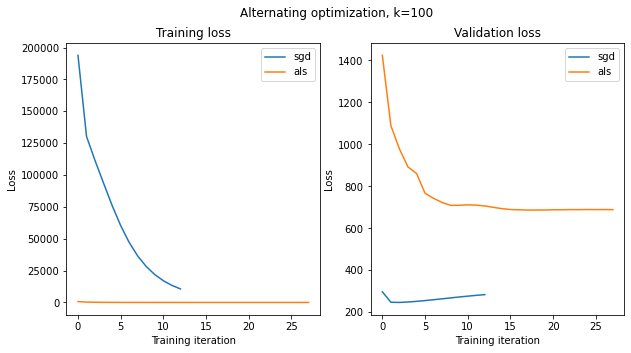

In [54]:
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
fig.suptitle("Alternating optimization, k=100")

ax[0].plot(train_loss_sgd[1::], label='sgd')
ax[0].plot(train_loss_als[1::], label='als')
ax[0].set_title('Training loss')
ax[0].set_xlabel("Training iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()


ax[1].plot(val_loss_sgd[1::], label='sgd')
ax[1].plot(val_loss_als[1::], label='als')
ax[1].set_title('Validation loss')
ax[1].set_xlabel("Training iteration")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.show()

# Autoencoder and t-SNE

Hereinafter, we will implement an autoencoder and analyze its latent space via interpolations and t-SNE. For this, we will use the famous Fashion-MNIST dataset.

In [55]:
from typing import List

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torchvision
from torchvision.datasets import FashionMNIST
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

**Hint:** If you run into memory issues simply reduce the `batch_size`

In [56]:
train_dataset = FashionMNIST(root='data', download=True, train=True, transform=torchvision.transforms.ToTensor())
test_dataset = FashionMNIST(root='data', download=True, train=False, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True, 
                                           num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, 
                                          num_workers=2, pin_memory=True)

### Task 4: Define decoder network

Feel free to choose any architecture you like. Our model was this:
```
Autoencoder(
  (encode): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
  )
  (decode): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
    (10): Sigmoid()
  )
)
```

In [57]:
class Autoencoder(nn.Module):
    ## BEGIN SOLUTION
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encode = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(negative_slope=0.01)
            
          )            
        self.decode =  nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(1, 1)),
            nn.Sigmoid()
      )
    ## END SOLUTION
    def forward(self, x):
        z = self.encode(x)
        x_approx = self.decode(z)
        
        assert x.shape == x_approx.shape
        return x_approx
    
print(Autoencoder())

Autoencoder(
  (encode): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
  )
  (decode): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    

In [58]:
x = test_dataset[0][0][None, ...]
z = Autoencoder().encode(x)

print(x.shape)
print(z.shape)
print(Autoencoder().decode(z).shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 32, 3, 3])
torch.Size([1, 1, 28, 28])


We see that our model transform the image from $28 \cdot 28 = 784$ dimensional space down into a $32 \cdot 3 \cdot 3 = 288$ dimensional space. However, note that the latent space also must contain some spatial information that the decoder needs for decoding.

## Task 5: Train the autoencoder

Of course, we must train the autoencoder if we want to analyze it later on.

In [71]:
device = 0 if torch.cuda.is_available() else 'cpu'
model = Autoencoder().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.999)

log_every_batch = 20

for epoch in range(50):
    model.train()
    train_loss_trace = []
    for batch, (x, _) in enumerate(train_loader):
        # TODO: The autoendocer shall be trained on the mse loss
        ## BEGIN SOLUTION
        x = x.to(device)
        x_approx = model(x)
        loss = F.mse_loss(x_approx, x)
        
        #do the optimazation step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ## END SOLUTION
        train_loss_trace.append(loss.detach().item())
        if batch % log_every_batch == 0:
            print(f'Training: Epoch {epoch} batch {batch} - loss {loss}')
    
    model.eval()
    test_loss_trace = []
    for batch, (x, _) in enumerate(test_loader):
        x = x.to(device)
        x_approx = model(x)
        loss = F.mse_loss(x_approx, x)
        test_loss_trace.append(loss.detach().item())
        if batch % log_every_batch == 0:
            print(f'Test: Epoch {epoch} batch {batch} loss {loss}')
    print(f'Epoch {epoch} finished - average train loss {np.mean(train_loss_trace)}, '
          f'average test loss {np.mean(test_loss_trace)}')

Training: Epoch 0 batch 0 - loss 0.14706005156040192
Training: Epoch 0 batch 20 - loss 0.06465480476617813
Training: Epoch 0 batch 40 - loss 0.0453634075820446
Test: Epoch 0 batch 0 loss 0.047963134944438934
Epoch 0 finished - average train loss 0.06594517650240558, average test loss 0.047712722793221474
Training: Epoch 1 batch 0 - loss 0.03605988621711731
Training: Epoch 1 batch 20 - loss 0.030334750190377235
Training: Epoch 1 batch 40 - loss 0.02665037102997303
Test: Epoch 1 batch 0 loss 0.02428355999290943
Epoch 1 finished - average train loss 0.028992763515246118, average test loss 0.024083339236676694
Training: Epoch 2 batch 0 - loss 0.023771077394485474
Training: Epoch 2 batch 20 - loss 0.021721726283431053
Training: Epoch 2 batch 40 - loss 0.019966477528214455
Test: Epoch 2 batch 0 loss 0.020348669961094856
Epoch 2 finished - average train loss 0.021455874698141874, average test loss 0.020190178602933883
Training: Epoch 3 batch 0 - loss 0.020078575238585472
Training: Epoch 3 bat

Training: Epoch 26 batch 40 - loss 0.010514012537896633
Test: Epoch 26 batch 0 loss 0.010985438711941242
Epoch 26 finished - average train loss 0.010616078720254413, average test loss 0.010878991335630417
Training: Epoch 27 batch 0 - loss 0.010579789988696575
Training: Epoch 27 batch 20 - loss 0.010084904730319977
Training: Epoch 27 batch 40 - loss 0.010386868380010128
Test: Epoch 27 batch 0 loss 0.010783007368445396
Epoch 27 finished - average train loss 0.010547728040965937, average test loss 0.01066494444385171
Training: Epoch 28 batch 0 - loss 0.010532771237194538
Training: Epoch 28 batch 20 - loss 0.010399558581411839
Training: Epoch 28 batch 40 - loss 0.010425668209791183
Test: Epoch 28 batch 0 loss 0.010375896468758583
Epoch 28 finished - average train loss 0.010413437071493116, average test loss 0.010265494883060455
Training: Epoch 29 batch 0 - loss 0.01022573933005333
Training: Epoch 29 batch 20 - loss 0.01045297272503376
Training: Epoch 29 batch 40 - loss 0.010570733807981014

In [72]:
model.eval()
with torch.no_grad():
    latent = []
    for batch, (x, _) in enumerate(test_loader):
        latent.append(model.encode(x.to(device)).cpu())
    latent = torch.cat(latent)

## PCA and t-SNE (nothing to do here)
Next, we are going to look at some random images and their embeddings. Since 7x7 is still too large to visialize further dimensionality reduction techniques are required. 

It is not uncommand that a neural network designer wants to understand whats going on in the latent space and therefore uses techniques such as t-SNE.

In [73]:
def plot_latent(test_dataset: torch.utils.data.Dataset, z_test: torch.Tensor, count: int, 
                technique: str, perplexity: float = 30):
    """
    Fit t-SNE or PCA and plots the latent space. Moreover, we then display the correspeondig image.
    
    Parameters
    ----------
    test_dataset  : torch.utils.data.DataSet
                    Dataset containing raw images to display.
    z_test        : torch.Tensor
                    The transformed images.
    count         : int
                    Number of random images to sample
    technique     : str
                    Either "pca" or "tsne". Otherwise, a ValueError is thrown.
    perplexity    : float, optional, default: 30.0
                    Perplexity is t-SNE is used.
        
    """
    indices = np.random.choice(len(z_test), count, replace=False)
    inputs = z_test[indices]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'pca':
        coords = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2, perplexity=perplexity).fit_transform(inputs.reshape(count, -1))
    else:
        raise ValueError()

    for idx, (x, y) in zip(indices, coords):
        im = OffsetImage(test_dataset[idx][0].squeeze().numpy(), zoom=1, cmap='gray')
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
        ax.add_artist(ab)
    ax.update_datalim(coords)
    ax.autoscale()
    plt.show()

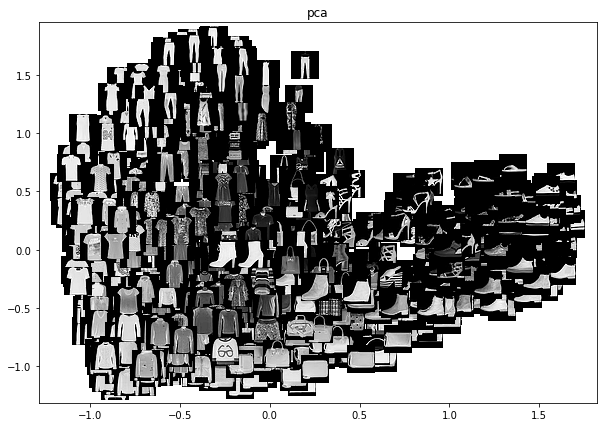

In [74]:
plot_latent(test_dataset, latent, 1000, 'pca')

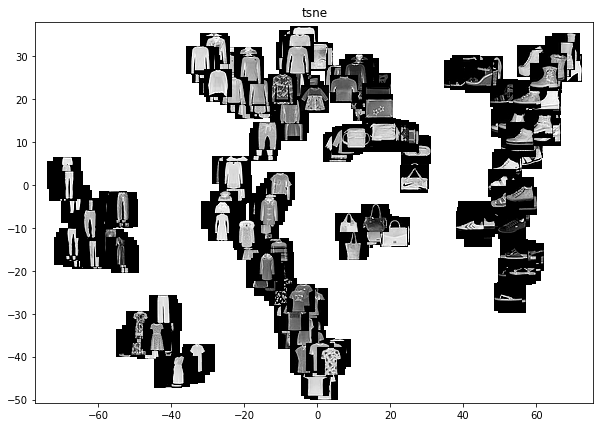

In [75]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=5)

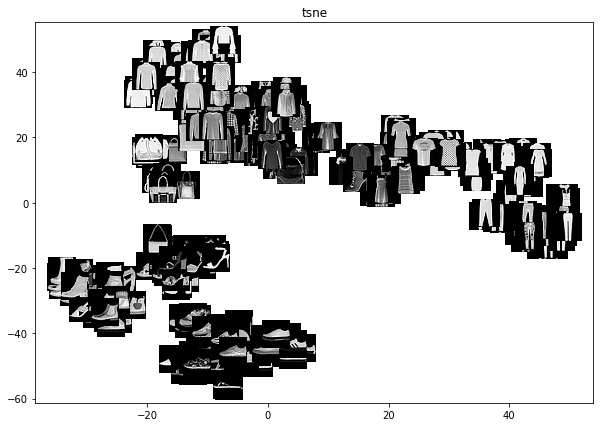

In [76]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=10)

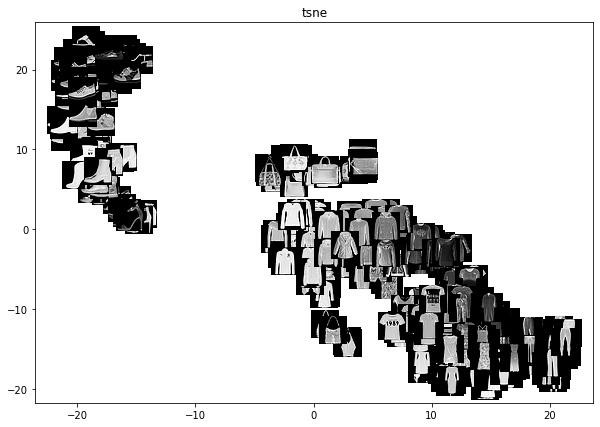

In [77]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=30)

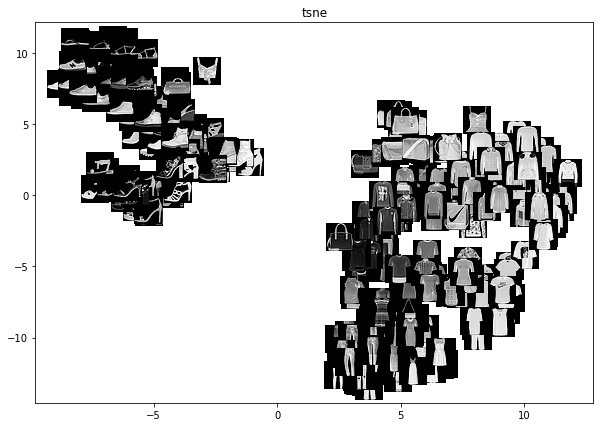

In [78]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=50)

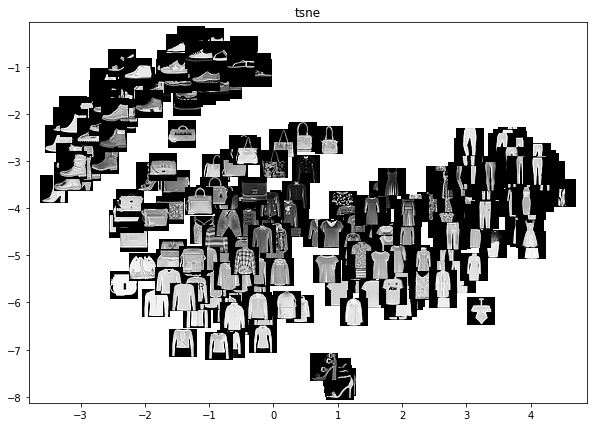

In [79]:
plot_latent(test_dataset, latent, 300, 'tsne', perplexity=150)

## Task 6: Linear Interpolation on the latent space
If the latent space has learned something meanigfull, we can leverage this for further analysis/downstream tasks. Anyways, we were wondering all along how the interpolation between a shoe and a pullover might look like.

For this we encode two images $z_i = f_{enc}(x_i)$ and $z_j = f_{enc}(x_j)$. Then we linearily interpolate $k$ equidistant locations on the line between $z_i$ and $z_j$. Those locations are then be decooded by the decoder network $f_{dec}(\dots)$.

In [80]:
def interpolate_between(model: Autoencoder, test_dataset: torch.utils.data.Dataset, idx_i: int, idx_j: int, n = 12):
    """
    Plot original images and the reconstruction of the linear interpolation in the respective latent space embedding.
    
    Parameters
    ----------
    model         : Autoencoder
                    The (trained) autoencoder.
    test_dataset  : torch.utils.data.Dataset
                    Test images.
    idx_i         : int
                    Id for first image.
    idx_j         : int
                    Id for second image.
    n             : n, optional, default: 1
                    Number of intermediate interoplations (including original reconstructions).
        
    """
    fig, ax = plt.subplots(1, 2, figsize=[6, 4])
    fig.suptitle("Original images")
    ax[0].imshow(test_dataset[idx_i][0][0].numpy(), cmap='gray')
    ax[1].imshow(test_dataset[idx_j][0][0].numpy(), cmap='gray')
    
    # Get embedding
    z_i = model.encode(test_dataset[idx_i][0].to(device)[None, ...])[0]
    z_j = model.encode(test_dataset[idx_j][0].to(device)[None, ...])[0]
    
    fig, ax = plt.subplots(2, n//2, figsize=[15, 8])
    ax = [sub for row in ax for sub in row]
    fig.suptitle("Reconstruction after interpolation in latent space")

    with torch.no_grad():
        # TODO: Linearily interpolate between `z_i` and `z_j` in `n` equidistant steps. 
        # Then decode the embedding and plot the image and add the percentage as a title.
        ## BEGIN SOLUTION
        
        #interpolation
        intpo_1 = (z_j - z_i)/11
        for i in range (12):
            encoded_image_i = z_i+intpo_1*i
            decoded_image_i = model.decode(encoded_image_i.to(device)[None, ...])[0]
            image_i = decoded_image_i.numpy().reshape(28,28)
        
        #plot the images        
            ax[i].imshow(image_i, cmap='gray')
            num = round(((i/11)*100),2)
            ax[i].set_title("interpolation {}%".format(num))
            
        ## END SOLUTION

    plt.show()

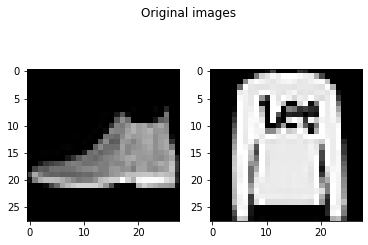

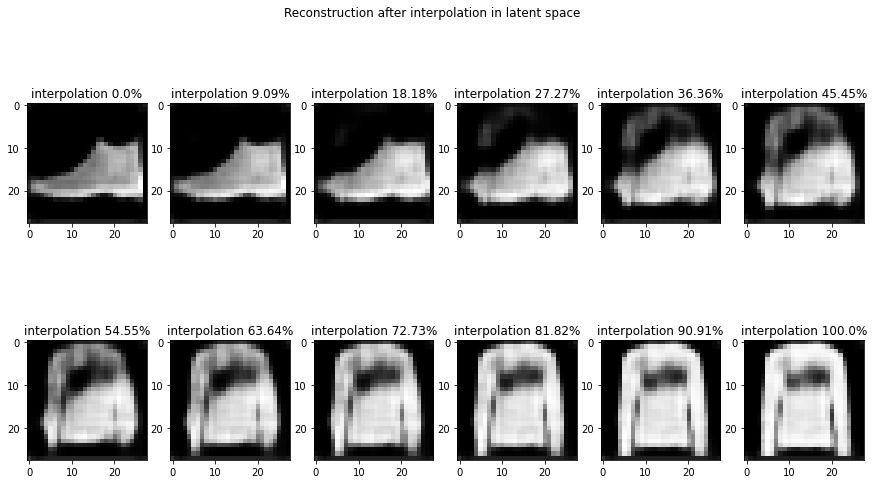

In [81]:
interpolate_between(model, test_dataset, 0, 1)

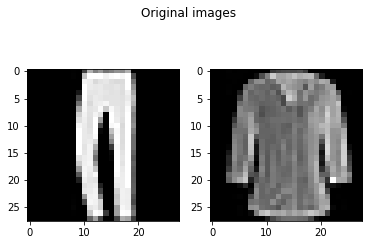

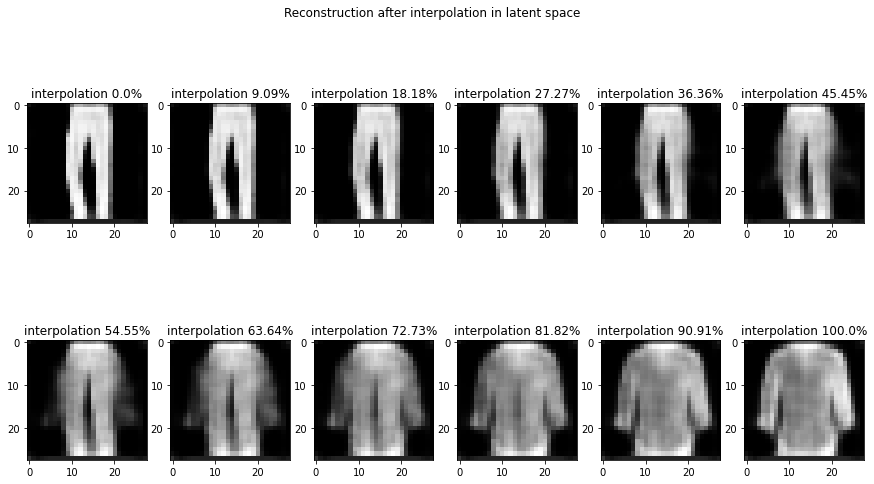

In [82]:
interpolate_between(model, test_dataset, 2, 4)

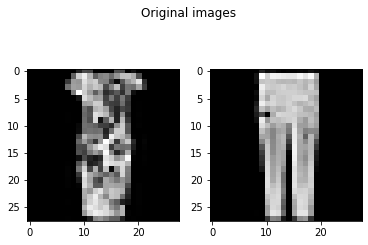

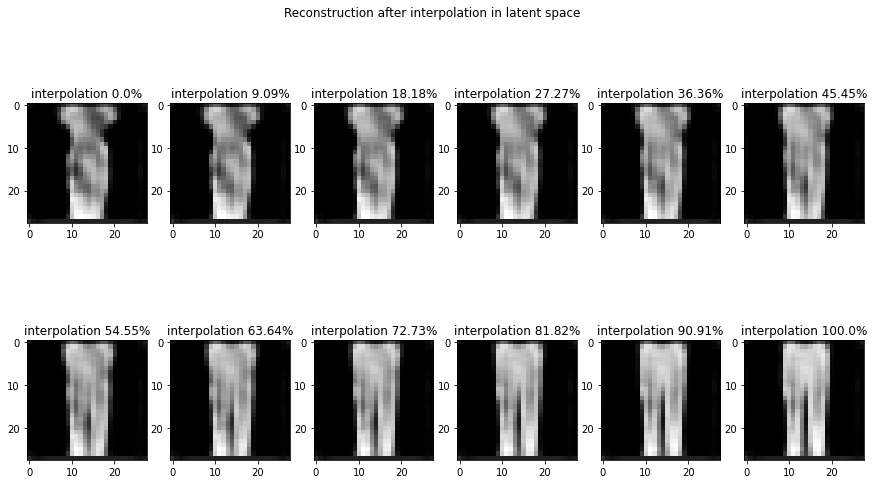

In [83]:
interpolate_between(model, test_dataset, 100, 200)